# Installing Requirements

In [ ]:
!pip install torch transformers datasets evaluate pillow==9.2.0
!pip install git+https://github.com/rwightman/pytorch-image-models.git

# # Restart Kernel
import os

os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-klmeh4tr
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-klmeh4tr
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit f9a24fa19f3dd10722d61f7b0bb149e2d5a8bdf2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-0.9.3.dev0-py3-none-any.whl size=2183065 sha256=bdef8031e9b1da62d6c2ce7cd8bc057f2e17ee69fb3a1a6a647d240638302fa4
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7omsbsh/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intialize Training

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil

## Data Processing

In [ ]:
train_files = glob.glob("/content/BUU-LSPINE_gender/train/**/*.jpg")
test_files = glob.glob("/content/BUU-LSPINE_gender/test/*.jpg")

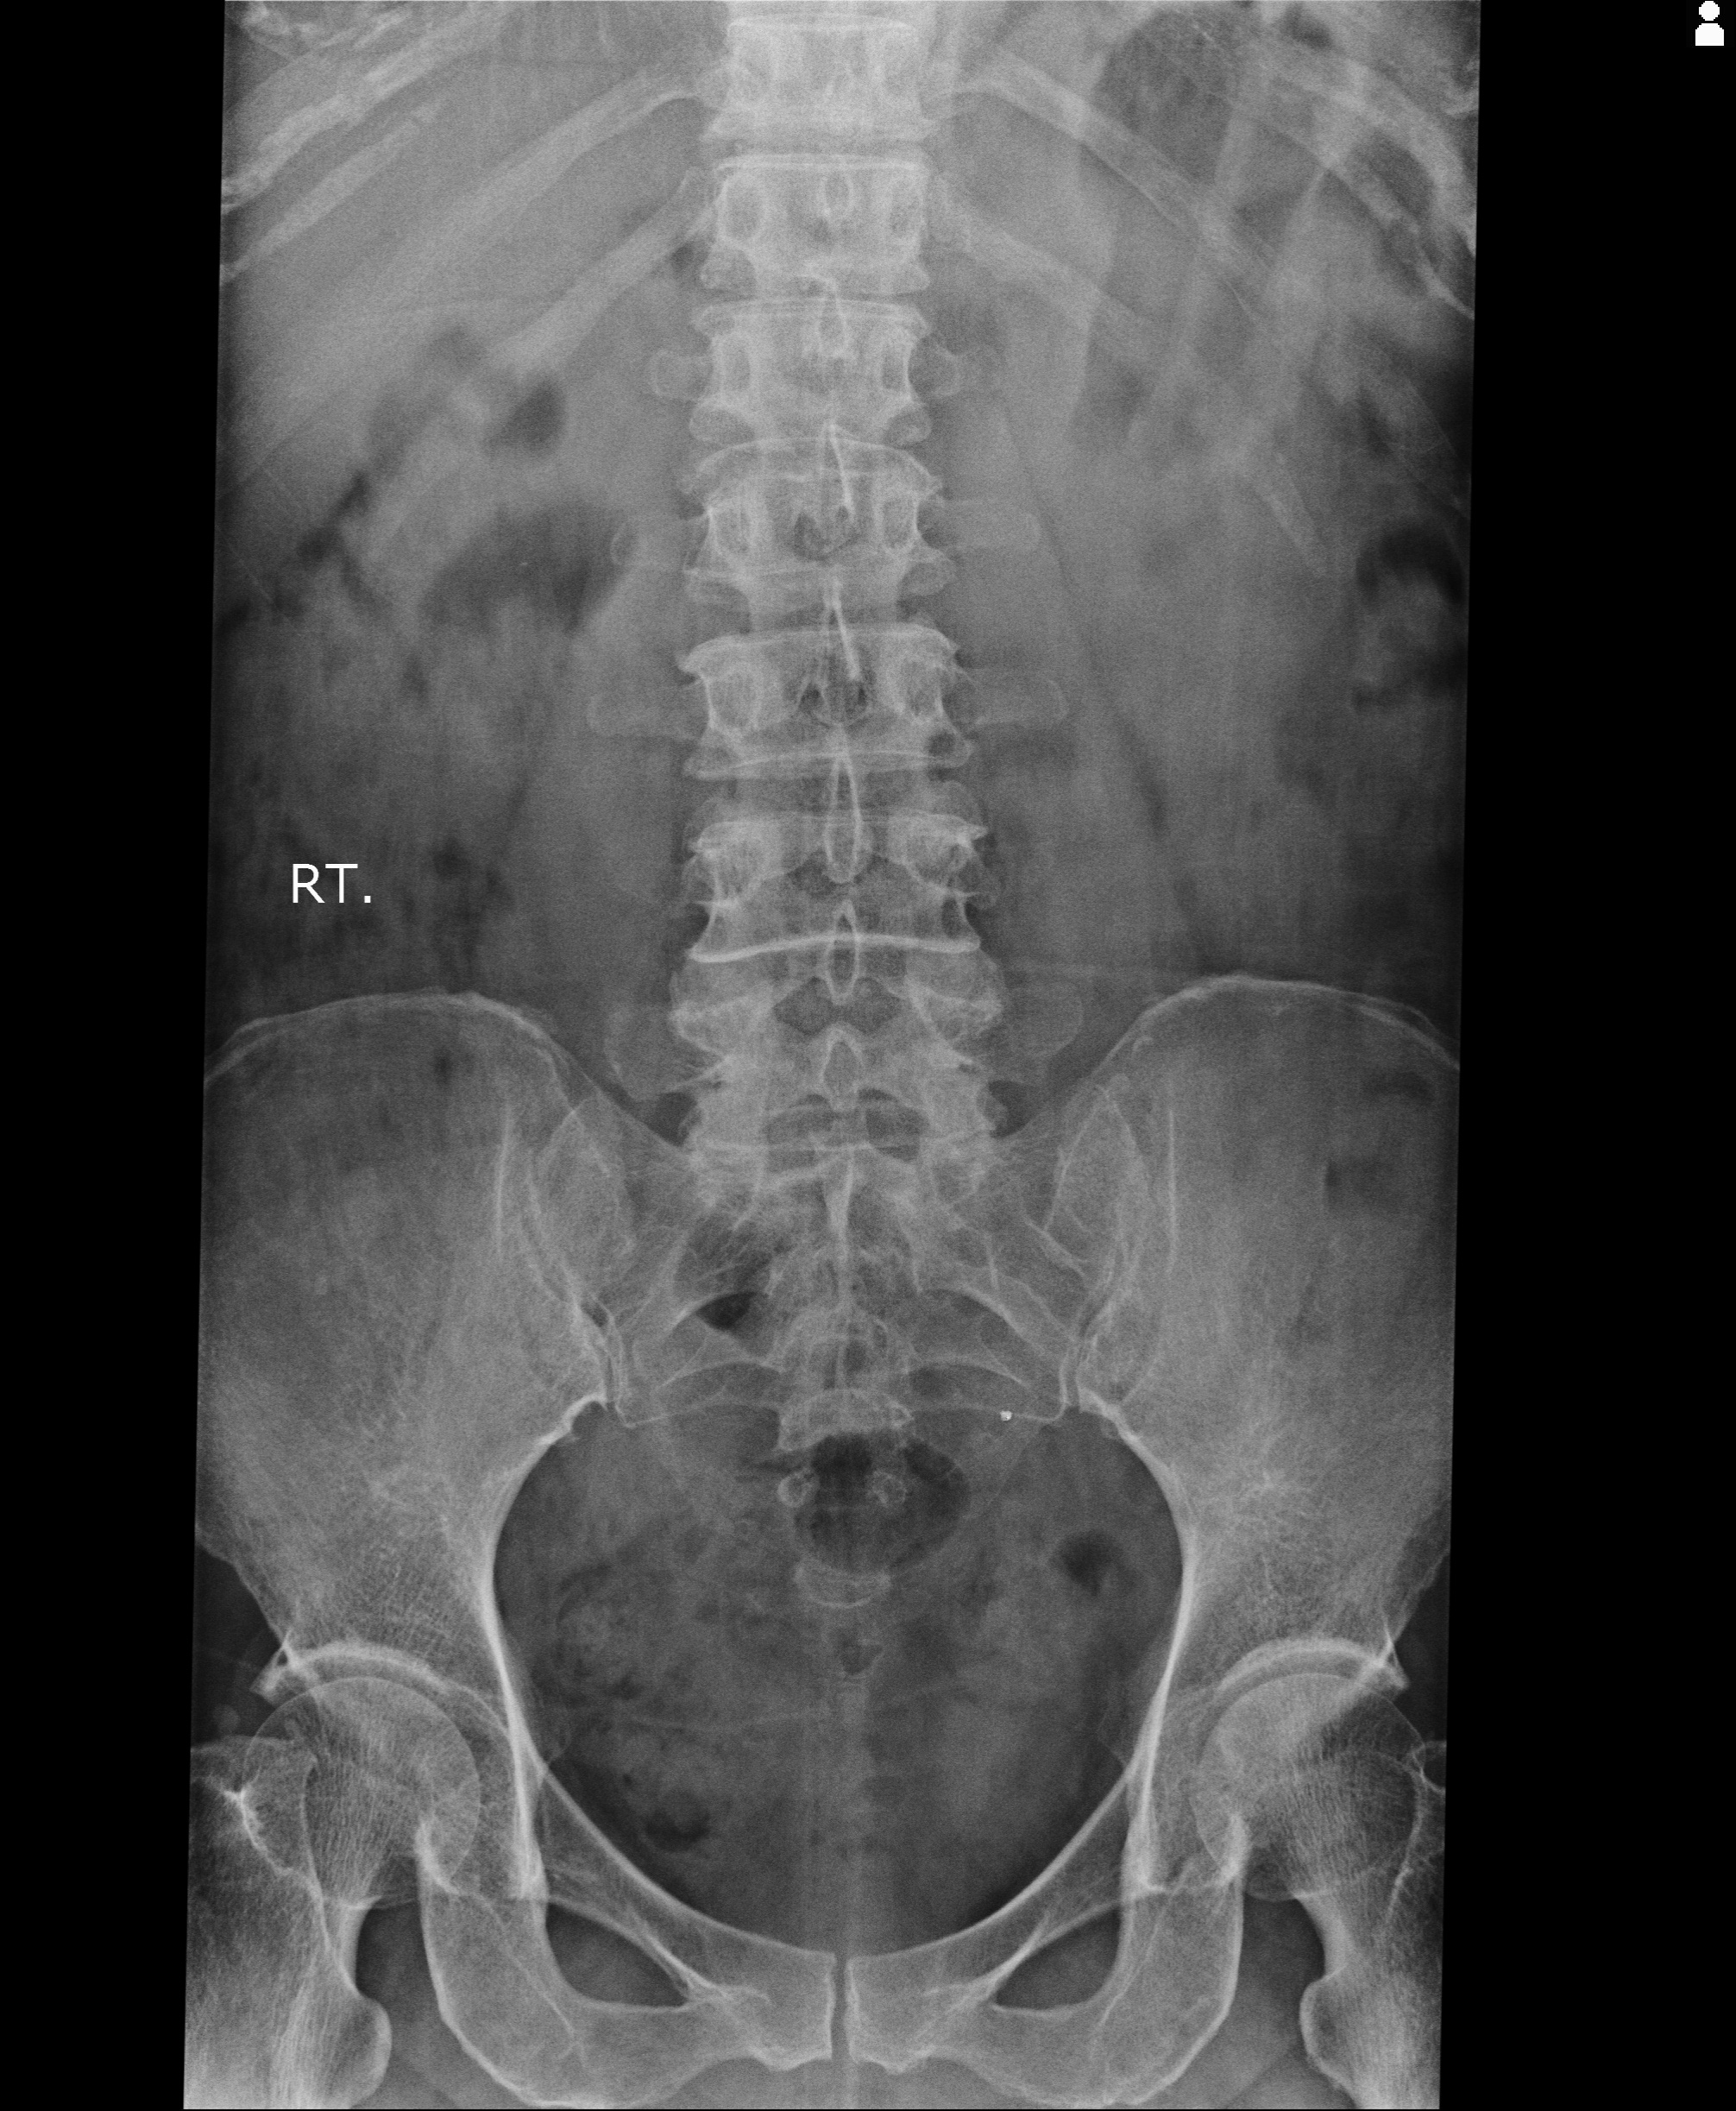

In [ ]:
example = Image.open(train_files[0]).convert("RGB")
display(example)

In [ ]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet
from PIL import Image
from torchvision.transforms import functional as F

class NoiseReduction(object):
    def __call__(self, img):
        img_array = np.array(img)
        img_denoised = denoise_wavelet(img_array, multichannel=True)
        img_denoised = Image.fromarray((img_denoised * 255).astype(np.uint8))
        return img_denoised




<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


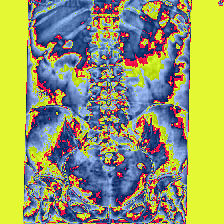

In [ ]:
import torchvision.transforms as T
transforms = {
    "train": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        NoiseReduction(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        NoiseReduction(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

toImage = T.ToPILImage()
toImage(transforms["train"](example))

In [ ]:
dataset = ImageDataset("/content/BUU-LSPINE_gender/train", transform=transforms["train"])

# Model Training

In [ ]:
# List all available models
timm.list_models("")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "timm/maxvit_large_tf_224.in1k"

In [ ]:
num_epochs = 6
criterion = nn.CrossEntropyLoss()

# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 32
eval_batch_size = 32
num_accumulate = 4
–
# Cross Validation Configuration
k_splits = 3
metric = evaluate.load("f1")


In [ ]:
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [ ]:
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of 5")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        # Train Loop
        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            loss.backward()

            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()

        optimizer.sync_lookahead()
        scheduler.step(epoch + 1)

        # Eval Loop
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()

        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
            print("New Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"checkpoint_fold{fold}.pt")

        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.7234501199988126], 'metric_val': [0.732442027906053], 'train_loss': [0.5052104730214646], 'val_loss': [0.6708037998691639], 'best_metric_val': 0.732442027906053}
Fold: 0 | Epoch: 0 | Metric: 0.732442027906053 | Training Loss: 0.5052104730214646 | Validation Loss: 0.6708037998691639


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.7234501199988126, 0.908424744014316], 'metric_val': [0.732442027906053, 0.8919563203314491], 'train_loss': [0.5052104730214646, 0.19431336807893285], 'val_loss': [0.6708037998691639, 0.2814871961634387], 'best_metric_val': 0.8919563203314491}
Fold: 0 | Epoch: 1 | Metric: 0.8919563203314491 | Training Loss: 0.19431336807893285 | Validation Loss: 0.2814871961634387


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.7234501199988126, 0.908424744014316, 0.9691161991544239], 'metric_val': [0.732442027906053, 0.8919563203314491, 0.9364773927810679], 'train_loss': [0.5052104730214646, 0.19431336807893285, 0.08105683464334527], 'val_loss': [0.6708037998691639, 0.2814871961634387, 0.16363516838892417], 'best_metric_val': 0.9364773927810679}
Fold: 0 | Epoch: 2 | Metric: 0.9364773927810679 | Training Loss: 0.08105683464334527 | Validation Loss: 0.16363516838892417


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.7234501199988126, 0.908424744014316, 0.9691161991544239, 0.9907176566156704], 'metric_val': [0.732442027906053, 0.8919563203314491, 0.9364773927810679, 0.958985200845666], 'train_loss': [0.5052104730214646, 0.19431336807893285, 0.08105683464334527, 0.03676769640227196], 'val_loss': [0.6708037998691639, 0.2814871961634387, 0.16363516838892417, 0.11215277676306226], 'best_metric_val': 0.958985200845666}
Fold: 0 | Epoch: 3 | Metric: 0.958985200845666 | Training Loss: 0.03676769640227196 | Validation Loss: 0.11215277676306226


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

{'metric_train': [0.7234501199988126, 0.908424744014316, 0.9691161991544239, 0.9907176566156704, 0.9989699055964116], 'metric_val': [0.732442027906053, 0.8919563203314491, 0.9364773927810679, 0.958985200845666, 0.9589269506304905], 'train_loss': [0.5052104730214646, 0.19431336807893285, 0.08105683464334527, 0.03676769640227196, 0.0075216661381132125], 'val_loss': [0.6708037998691639, 0.2814871961634387, 0.16363516838892417, 0.11215277676306226, 0.11302610754501075], 'best_metric_val': 0.958985200845666}
Fold: 0 | Epoch: 4 | Metric: 0.9589269506304905 | Training Loss: 0.0075216661381132125 | Validation Loss: 0.11302610754501075


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.7234501199988126, 0.908424744014316, 0.9691161991544239, 0.9907176566156704, 0.9989699055964116, 0.9994847936843869], 'metric_val': [0.732442027906053, 0.8919563203314491, 0.9364773927810679, 0.958985200845666, 0.9589269506304905, 0.9612704174228675], 'train_loss': [0.5052104730214646, 0.19431336807893285, 0.08105683464334527, 0.03676769640227196, 0.0075216661381132125, 0.004000332114397923], 'val_loss': [0.6708037998691639, 0.2814871961634387, 0.16363516838892417, 0.11215277676306226, 0.11302610754501075, 0.10194458661135286], 'best_metric_val': 0.9612704174228675}
Fold: 0 | Epoch: 5 | Metric: 0.9612704174228675 | Training Loss: 0.004000332114397923 | Validation Loss: 0.10194458661135286
Fold 2 of 5


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5077295216329302], 'metric_val': [0.392022792022792], 'train_loss': [0.6423888700221901], 'val_loss': [0.8028460048577365], 'best_metric_val': 0.392022792022792}
Fold: 1 | Epoch: 0 | Metric: 0.392022792022792 | Training Loss: 0.6423888700221901 | Validation Loss: 0.8028460048577365


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5077295216329302, 0.6185471127674668], 'metric_val': [0.392022792022792, 0.7493540051679586], 'train_loss': [0.6423888700221901, 0.5387275599276842], 'val_loss': [0.8028460048577365, 0.5090143365018508], 'best_metric_val': 0.7493540051679586}
Fold: 1 | Epoch: 1 | Metric: 0.7493540051679586 | Training Loss: 0.5387275599276842 | Validation Loss: 0.5090143365018508


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5077295216329302, 0.6185471127674668, 0.8815366505128166], 'metric_val': [0.392022792022792, 0.7493540051679586, 0.8422462785598892], 'train_loss': [0.6423888700221901, 0.5387275599276842, 0.261361284153675], 'val_loss': [0.8028460048577365, 0.5090143365018508, 0.3813594723229899], 'best_metric_val': 0.8422462785598892}
Fold: 1 | Epoch: 2 | Metric: 0.8422462785598892 | Training Loss: 0.261361284153675 | Validation Loss: 0.3813594723229899


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

{'metric_train': [0.5077295216329302, 0.6185471127674668, 0.8815366505128166, 0.9515785172419919], 'metric_val': [0.392022792022792, 0.7493540051679586, 0.8422462785598892, 0.5924117282676027], 'train_loss': [0.6423888700221901, 0.5387275599276842, 0.261361284153675, 0.1227003350687116], 'val_loss': [0.8028460048577365, 0.5090143365018508, 0.3813594723229899, 0.9247050945003352], 'best_metric_val': 0.8422462785598892}
Fold: 1 | Epoch: 3 | Metric: 0.5924117282676027 | Training Loss: 0.1227003350687116 | Validation Loss: 0.9247050945003352


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5077295216329302, 0.6185471127674668, 0.8815366505128166, 0.9515785172419919, 0.9782909116635492], 'metric_val': [0.392022792022792, 0.7493540051679586, 0.8422462785598892, 0.5924117282676027, 0.9439295445698714], 'train_loss': [0.6423888700221901, 0.5387275599276842, 0.261361284153675, 0.1227003350687116, 0.06253459980822544], 'val_loss': [0.8028460048577365, 0.5090143365018508, 0.3813594723229899, 0.9247050945003352, 0.17574894529602983], 'best_metric_val': 0.9439295445698714}
Fold: 1 | Epoch: 4 | Metric: 0.9439295445698714 | Training Loss: 0.06253459980822544 | Validation Loss: 0.17574894529602983


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

{'metric_train': [0.5077295216329302, 0.6185471127674668, 0.8815366505128166, 0.9515785172419919, 0.9782909116635492, 0.9910431834602346], 'metric_val': [0.392022792022792, 0.7493540051679586, 0.8422462785598892, 0.5924117282676027, 0.9439295445698714, 0.9430742890955035], 'train_loss': [0.6423888700221901, 0.5387275599276842, 0.261361284153675, 0.1227003350687116, 0.06253459980822544, 0.028224387908104196], 'val_loss': [0.8028460048577365, 0.5090143365018508, 0.3813594723229899, 0.9247050945003352, 0.17574894529602983, 0.16813662582460573], 'best_metric_val': 0.9439295445698714}
Fold: 1 | Epoch: 5 | Metric: 0.9430742890955035 | Training Loss: 0.028224387908104196 | Validation Loss: 0.16813662582460573
Fold 3 of 5


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5158877159352739], 'metric_val': [0.6828100204035366], 'train_loss': [0.6317836504373977], 'val_loss': [0.5255091032561134], 'best_metric_val': 0.6828100204035366}
Fold: 2 | Epoch: 0 | Metric: 0.6828100204035366 | Training Loss: 0.6317836504373977 | Validation Loss: 0.5255091032561134


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5158877159352739, 0.7923664045170398], 'metric_val': [0.6828100204035366, 0.9035730438715514], 'train_loss': [0.6317836504373977, 0.4101142033712188], 'val_loss': [0.5255091032561134, 0.2783723784720196], 'best_metric_val': 0.9035730438715514}
Fold: 2 | Epoch: 1 | Metric: 0.9035730438715514 | Training Loss: 0.4101142033712188 | Validation Loss: 0.2783723784720196


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5158877159352739, 0.7923664045170398, 0.946332515143591], 'metric_val': [0.6828100204035366, 0.9035730438715514, 0.9150379087868684], 'train_loss': [0.6317836504373977, 0.4101142033712188, 0.15222845304368146], 'val_loss': [0.5255091032561134, 0.2783723784720196, 0.20709979917634935], 'best_metric_val': 0.9150379087868684}
Fold: 2 | Epoch: 2 | Metric: 0.9150379087868684 | Training Loss: 0.15222845304368146 | Validation Loss: 0.20709979917634935


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

{'metric_train': [0.5158877159352739, 0.7923664045170398, 0.946332515143591, 0.9682163439199909], 'metric_val': [0.6828100204035366, 0.9035730438715514, 0.9150379087868684, 0.9017650889896013], 'train_loss': [0.6317836504373977, 0.4101142033712188, 0.15222845304368146, 0.08277808296591488], 'val_loss': [0.5255091032561134, 0.2783723784720196, 0.20709979917634935, 0.24551710653502276], 'best_metric_val': 0.9150379087868684}
Fold: 2 | Epoch: 3 | Metric: 0.9017650889896013 | Training Loss: 0.08277808296591488 | Validation Loss: 0.24551710653502276


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5158877159352739, 0.7923664045170398, 0.946332515143591, 0.9682163439199909, 0.9890288981085903], 'metric_val': [0.6828100204035366, 0.9035730438715514, 0.9150379087868684, 0.9017650889896013, 0.9537370198529179], 'train_loss': [0.6317836504373977, 0.4101142033712188, 0.15222845304368146, 0.08277808296591488, 0.03205417324232855], 'val_loss': [0.5255091032561134, 0.2783723784720196, 0.20709979917634935, 0.24551710653502276, 0.12544048359781942], 'best_metric_val': 0.9537370198529179}
Fold: 2 | Epoch: 4 | Metric: 0.9537370198529179 | Training Loss: 0.03205417324232855 | Validation Loss: 0.12544048359781942


  0%|          | 0/67 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/34 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.5158877159352739, 0.7923664045170398, 0.946332515143591, 0.9682163439199909, 0.9890288981085903, 0.9963429660361968], 'metric_val': [0.6828100204035366, 0.9035730438715514, 0.9150379087868684, 0.9017650889896013, 0.9537370198529179, 0.9635691137168976], 'train_loss': [0.6317836504373977, 0.4101142033712188, 0.15222845304368146, 0.08277808296591488, 0.03205417324232855, 0.014301010212902702], 'val_loss': [0.5255091032561134, 0.2783723784720196, 0.20709979917634935, 0.24551710653502276, 0.12544048359781942, 0.11134835095692645], 'best_metric_val': 0.9635691137168976}
Fold: 2 | Epoch: 5 | Metric: 0.9635691137168976 | Training Loss: 0.014301010212902702 | Validation Loss: 0.11134835095692645


In [ ]:
!cp /content/checkpoint_fold0.pt /content/drive/MyDrive/lumbargender-check

# Error Analysis

  0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


Fold: 0


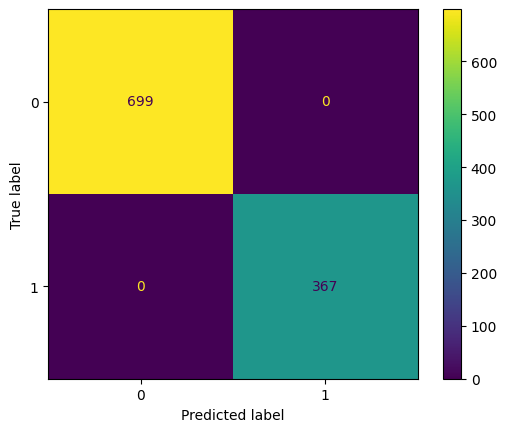

  0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


Fold: 1


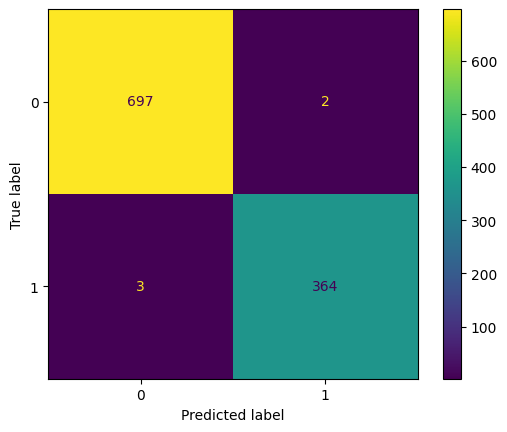

  0%|          | 0/34 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


Fold: 2


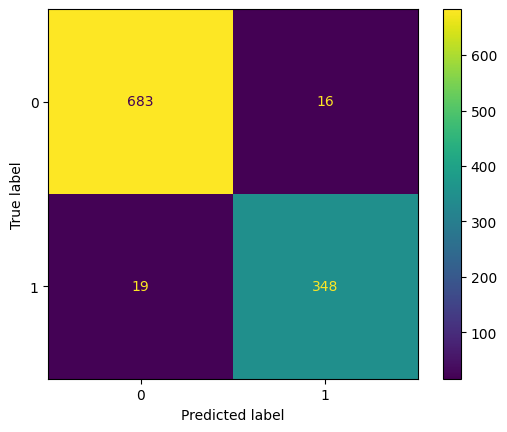

In [ ]:
for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")
    predictions = []
    references = []

    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            # Log Values
            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"Fold: {fold}")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


# Inference

## Voting Classifier


In [ ]:
answers_final = dict()

for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    model.eval()
    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]

            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)

            if fold == 0:
                answers_final[key] = [loaded_model(transformed).argmax(-1).item()]
            else:
                answers_final[key].append(loaded_model(transformed).argmax(-1).item())

for key in answers_final:
    # Take most occuring number
    answers_final[key] = stats.mode(answers_final[key])[0][0]


  0%|          | 0/800 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

<ipython-input-24-611c4ae8e67e>:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  answers_final[key] = stats.mode(answers_final[key])[0][0]


In [ ]:
with open(f"solution_maxvit_kfold{k_splits}_voting-1.csv", "w") as f:
    f.write("id,gender\n")
    for name in answers_final:
        f.write(f"{name}.jpg,{answers_final[name]}\n")

In [ ]:
import csv

input_file = '/content/solution_maxvit_kfold3_voting-1.csv'
output_file = 'output-gender.csv'

# Define the mapping of values
gender_mapping = {'0': 'F', '1': 'M'}

# Open input and output files
with open(input_file, 'r') as csv_in, open(output_file, 'w', newline='') as csv_out:
    reader = csv.DictReader(csv_in)
    writer = csv.DictWriter(csv_out, fieldnames=reader.fieldnames)
    writer.writeheader()

    # Process each row in the input file
    for row in reader:
        # Change the gender value based on the mapping
        if row['gender'] in gender_mapping:
            row['gender'] = gender_mapping[row['gender']]

        # Write the modified row to the output file
        writer.writerow(row)

print("CSV file processed successfully.")


CSV file processed successfully.


In [ ]:
!cp /content/output-gender.csv /content/drive/MyDrive/lumbargender-check

### Weighted Ensemble

In [ ]:
answers_final = dict()

for fold in range(k_splits):
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    model.eval()

    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]

            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)

            if fold == 0:
                answers_final[key] = loaded_model(transformed).cpu().numpy() * all_eval_scores[fold]
            else:
                answers_final[key] = answers_final[key] + (loaded_model(transformed).cpu().numpy() * all_eval_scores[fold])

answers_raw = copy(answers_final)

for key in answers_final:
    # Take most occuring number
    answers_final[key] = np.argmax(answers_final[key], -1).item()

  0%|          | 0/800 [00:00<?, ?it/s]

<ipython-input-6-304b08ed53c5>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_denoised = denoise_wavelet(img_array, multichannel=True)


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
with open(f"solution_maxvit_kfold{k_splits}_weighted.csv", "w") as f:
    f.write("id,gender\n")
    for name in answers_final:
        f.write(f"{name}.jpg,{answers_final[name]}\n")

In [ ]:
import csv

input_file = '/content/solution_maxvit_kfold3_weighted.csv'
output_file = 'output-gender-weight.csv'

# Define the mapping of values
gender_mapping = {'0': 'F', '1': 'M'}

# Open input and output files
with open(input_file, 'r') as csv_in, open(output_file, 'w', newline='') as csv_out:
    reader = csv.DictReader(csv_in)
    writer = csv.DictWriter(csv_out, fieldnames=reader.fieldnames)
    writer.writeheader()

    # Process each row in the input file
    for row in reader:
        # Change the gender value based on the mapping
        if row['gender'] in gender_mapping:
            row['gender'] = gender_mapping[row['gender']]

        # Write the modified row to the output file
        writer.writerow(row)

print("CSV file processed successfully.")

CSV file processed successfully.


# Pseudo Labeling

In [ ]:
softmax = nn.Softmax()

In [ ]:
to_move = {x: [] for x in range(2)}
threshold = 0.9

for key in answers_raw:
    predicted_class = np.argmax(answers_raw[key], -1).item()

    if softmax(torch.tensor(answers_raw[key]))[predicted_class].item() > threshold:
        to_move[predicted_class].append(key)


<ipython-input-35-89f3a3f46a76>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if softmax(torch.tensor(answers_raw[key]))[predicted_class].item() > threshold:


RuntimeError: ignored

In [ ]:
for pred_class in to_move:
    for item in to_move[pred_class]:
        file_name = item.split("/")[-1]
        shutil.copyfile(item, f"signal/signal_train/{pred_class}/{file_name}")

# CSV Ensemble

In [ ]:
all_submissions = glob.glob("*.csv")

In [ ]:
all_answers = dict()

for idx, submission in enumerate(all_submissions):
    df = pd.read_csv(submission)
    mapper = {}
    for i in range(len(df)):
        mapper[df.id[i]] = df['gender'][i]

    for key in mapper:
        if idx == 0:
            all_answers[key] = [mapper[key]]
        else:
            all_answers[key].append(mapper[key])


In [ ]:
real_answers = {}

for key in all_answers:
    # Take most occuring number
    real_answers[key] = stats.mode(all_answers[key])[0][0]

<ipython-input-33-63f5fc7216aa>:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  real_answers[key] = stats.mode(all_answers[key])[0][0]
<ipython-input-33-63f5fc7216aa>:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  real_answers[key] = stats.mode(all_answers[key])[0][0]


In [ ]:
with open(f"Voting-3-0-1.csv", "w") as f:
    f.write("id,gender\n")
    for name in real_answers:
        f.write(f"{name},{real_answers[name]}\n")